In [1]:
# === 1. Load Required Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
# === 2. Load Cluster Assignments ===
cluster_file = "/Users/denizadiguzel/player_clusters.csv"
player_clusters = pd.read_csv(cluster_file)

# === 3. Define Role Scores from Cluster IDs ===
role_map = {
    2: 0.0,                      # Goalkeepers
    5: 0.33,                     # Defense
    1: 0.66, 3: 0.66, 6: 0.66, 0: 0.66,  # Midfield
    4: 1.0                       # Attack
}
player_clusters["role_score"] = player_clusters["cluster"].map(role_map)


In [3]:
full_df = pd.read_hdf("/Users/denizadiguzel/cluster_data_all_vxy_detailed.h5", key="df")
full_df["team_extracted"] = full_df["player_id"].str.extract(r"player_([A-Z]+)_")[0]
full_df["number_extracted"] = full_df["player_id"].str.extract(r"player_[A-Z]+_([0-9]+)")[0]
full_df["label"] = full_df["team_extracted"] + "_" + full_df["number_extracted"]


team_means = full_df.groupby(["match_id", "team_extracted"])[["x", "y"]].mean().reset_index()
team_means = team_means.rename(columns={"x": "x_team_avg", "y": "y_team_avg"})
full_df = full_df.merge(team_means, on=["match_id", "team_extracted"], how="left")

full_df["x_rel"] = full_df["x"] - full_df["x_team_avg"]
full_df["y_rel"] = full_df["y"] - full_df["y_team_avg"]

player_stats = full_df.groupby("player_id")[["x_rel", "y_rel", "speed", "v_x", "v_y"]].mean()
player_stats["x_rel_std"] = full_df.groupby("player_id")["x_rel"].std().values
player_stats["y_rel_std"] = full_df.groupby("player_id")["y_rel"].std().values
player_stats["speed_std"] = full_df.groupby("player_id")["speed"].std().values
player_stats["label"] = full_df.groupby("player_id")["label"].first().values

player_stats = player_stats.merge(player_clusters[["label", "role_score", "cluster"]], on="label", how="inner")

In [4]:
# === 6. Sample 50% of Players Per Cluster for Training ===
train_df = (
    player_stats.reset_index()
    .groupby("cluster", group_keys=False)
    .apply(lambda x: x.sample(frac=0.95, random_state=42))
)
test_df  = player_stats.drop(train_df.index)

# === 7. Prepare Data for Regression ===
features = ["x_rel", "x_rel_std", "y_rel", "y_rel_std", "speed", "speed_std", "v_x", "v_y"]
X_train = train_df[features].values
y_train = train_df["role_score"].values
X_test = test_df[features].values
y_test = test_df["role_score"].values

# === 8. Normalize Input Features ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


/var/folders/07/x2s02cx91197jf2wqv2byvf80000gn/T/ipykernel_26279/2188128446.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(frac=0.95, random_state=42))


In [5]:
# === 9. Define and Train Neural Network ===
reg = MLPRegressor(hidden_layer_sizes=(32, 16), activation='relu', solver='adam',
                   max_iter=1000, random_state=42)
reg.fit(X_train_scaled, y_train)

MLPRegressor(hidden_layer_sizes=(32, 16), max_iter=1000, random_state=42)


=== Evaluation ===
Test MSE: 0.0331
Test R² : 0.4590


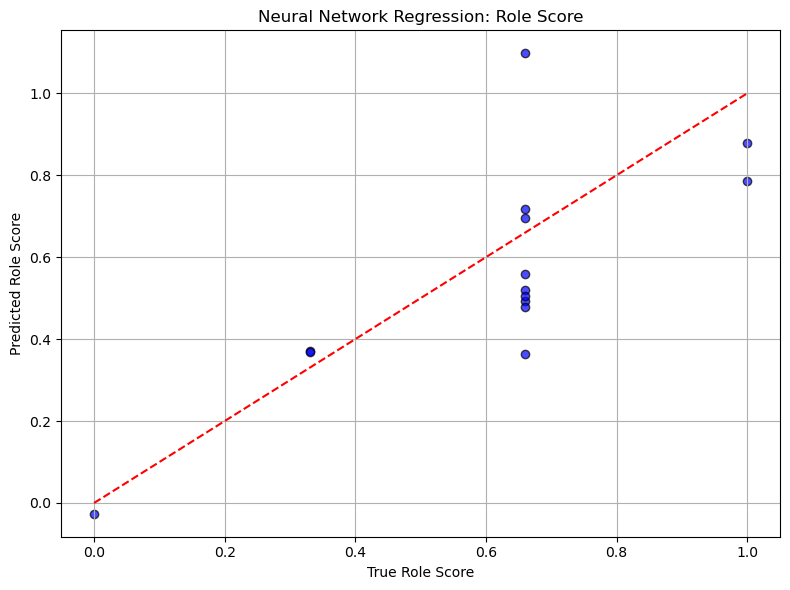

In [6]:
# === 10. Evaluate Model ===
y_pred = reg.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"\n=== Evaluation ===")
print(f"Test MSE: {mse:.4f}")
print(f"Test R² : {r2:.4f}")

# === 11. Visualize Predictions ===
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, c='blue', edgecolor='k', alpha=0.7)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel("True Role Score")
plt.ylabel("Predicted Role Score")
plt.title("Neural Network Regression: Role Score")
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
# === Create comparison table for test set ===
comparison_df = test_df.copy()
comparison_df = comparison_df[["label", "cluster", "role_score"]].copy()
comparison_df["predicted_score"] = y_pred

# === Map cluster to role name ===
role_name_map = {
    0.0: "Goalkeeper",
    0.33: "Defense",
    0.66: "Midfield",
    1.0: "Attack"
}
comparison_df["role_name"] = comparison_df["role_score"].map(role_name_map)

# === Sort for nicer display ===
comparison_df = comparison_df.sort_values("role_score").reset_index(drop=True)

# === Display as table ===
import pandas as pd
from IPython.display import display

display(comparison_df[["label", "role_name", "role_score", "predicted_score"]].round(3))


,label,role_name,role_score,predicted_score
0,BIF_16,Goalkeeper,0.00,-0.026
1,LYN_3,Defense,0.33,0.372
2,SJE_4,Defense,0.33,0.368
3,BIF_35,Midfield,0.66,0.494
4,FCK_2,Midfield,0.66,0.365
5,FCK_27,Midfield,0.66,0.478
6,FCM_29,Midfield,0.66,0.521
7,LYN_19,Midfield,0.66,0.560
8,RFC_30,Midfield,0.66,1.097
9,SIF_8,Midfield,0.66,0.717


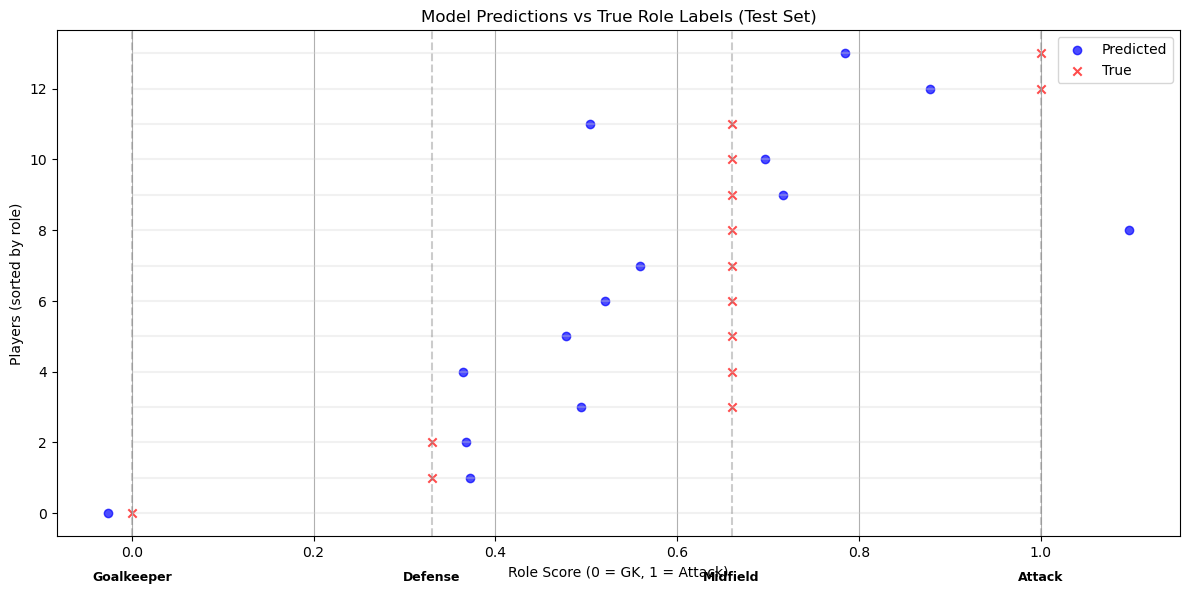

In [8]:
# === 1D Line Plot ===
plt.figure(figsize=(12, 6))
plt.hlines(y=range(len(comparison_df)), xmin=0, xmax=1, color='lightgray', alpha=0.3)

# Plot predictions
plt.scatter(comparison_df["predicted_score"], range(len(comparison_df)),
            color='blue', label='Predicted', alpha=0.7)

# Plot actual values
plt.scatter(comparison_df["role_score"], range(len(comparison_df)),
            color='red', marker='x', label='True', alpha=0.7)

# Role marker lines
for val, name in role_name_map.items():
    plt.axvline(val, color='gray', linestyle='--', alpha=0.4)
    plt.text(val, -2, name, ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel("Role Score (0 = GK, 1 = Attack)")
plt.ylabel("Players (sorted by role)")
plt.title("Model Predictions vs True Role Labels (Test Set)")
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


# TENSORFLOW 

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# === 1. Load player_cluster file and merge with data ===
cluster_file = "/Users/denizadiguzel/player_clusters.csv"
player_clusters = pd.read_csv(cluster_file)

role_map = {
    2: 0.0,
    5: 0.33,
    1: 0.66, 3: 0.66, 6: 0.66, 0: 0.66,
    4: 1.0
}
player_clusters["role_score"] = player_clusters["cluster"].map(role_map)

# === 2. Load full player dataset ===
df = pd.read_hdf("/Users/denizadiguzel/cluster_data_all_vxy_detailed.h5", key="df")
df["team_extracted"] = df["player_id"].str.extract(r"player_([A-Z]+)_")[0]
df["number_extracted"] = df["player_id"].str.extract(r"player_[A-Z]+_([0-9]+)")[0]
df["label"] = df["team_extracted"] + "_" + df["number_extracted"]

team_means = df.groupby(["match_id", "team_extracted"])[["x", "y"]].mean().reset_index()
team_means = team_means.rename(columns={"x": "x_team_avg", "y": "y_team_avg"})
df = df.merge(team_means, on=["match_id", "team_extracted"], how="left")
df["x_rel"] = df["x"] - df["x_team_avg"]
df["y_rel"] = df["y"] - df["y_team_avg"]

player_stats = df.groupby("player_id")[["x_rel", "y_rel", "speed", "v_x", "v_y"]].mean()
player_stats["x_rel_std"] = df.groupby("player_id")["x_rel"].std().values
player_stats["y_rel_std"] = df.groupby("player_id")["y_rel"].std().values
player_stats["speed_std"] = df.groupby("player_id")["speed"].std().values
player_stats["label"] = df.groupby("player_id")["label"].first().values

# Merge in cluster and role
player_stats = player_stats.merge(player_clusters[["label", "role_score", "cluster"]], on="label", how="inner")

# === 3. Train/Test Split: 50% per cluster ===
train_df = player_stats.groupby("cluster", group_keys=False).apply(lambda x: x.sample(frac=0.95, random_state=42))
test_df  = player_stats.drop(train_df.index)

# === 4. Prepare features and targets ===
features = ["x_rel", "x_rel_std", "y_rel", "y_rel_std", "speed", "speed_std"]
X_train = train_df[features].values
y_train = train_df["role_score"].values
X_test = test_df[features].values
y_test = test_df["role_score"].values

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 5. Build Keras Model ===
model = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # restricts output to [0, 1]
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
model.summary()

# === 6. Train ===
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=16,
                    validation_split=0.1, verbose=0)

# === 7. Predict ===
y_pred = model.predict(X_test_scaled).flatten()

# === 8. Evaluation ===
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

# Safe SMAPE
smape = 100 * np.mean(
    np.abs(y_pred - y_test) / (np.abs(y_pred) + np.abs(y_test) + 1e-6)
)

print(f"\nKeras Model Evaluation:")
print(f"Test MAE   : {mae:.4f}")
print(f"Test RMSE  : {rmse:.4f}")
print(f"Test R²    : {r2:.4f}")
print(f"Test SMAPE : {smape:.2f}%")
print(f"Min/Max prediction: {y_pred.min():.3f} / {y_pred.max():.3f}")



/var/folders/07/x2s02cx91197jf2wqv2byvf80000gn/T/ipykernel_26279/2233161573.py:44: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_df = player_stats.groupby("cluster", group_keys=False).apply(lambda x: x.sample(frac=0.95, random_state=42))
/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 32)             │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 769 (3.00 KB)

 Trainable params: 769 (3.00 KB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step

Keras Model Evaluation:
Test MAE   : 0.0029
Test RMSE  : 0.0037
Test R²    : 0.9998
Test SMAPE : 7.41%
Min/Max prediction: 0.001 / 1.000


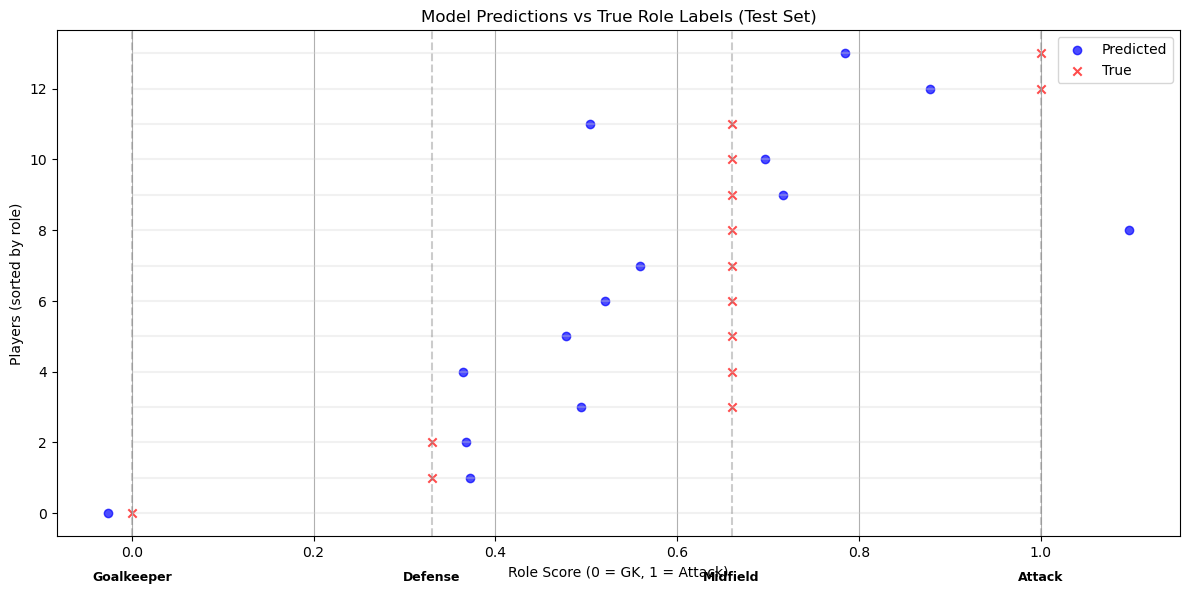

In [20]:
# === 1D Line Plot ===
plt.figure(figsize=(12, 6))
plt.hlines(y=range(len(comparison_df)), xmin=0, xmax=1, color='lightgray', alpha=0.3)

# Plot predictions
plt.scatter(comparison_df["predicted_score"], range(len(comparison_df)),
            color='blue', label='Predicted', alpha=0.7)

# Plot actual values
plt.scatter(comparison_df["role_score"], range(len(comparison_df)),
            color='red', marker='x', label='True', alpha=0.7)

# Role marker lines
for val, name in role_name_map.items():
    plt.axvline(val, color='gray', linestyle='--', alpha=0.4)
    plt.text(val, -2, name, ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.xlabel("Role Score (0 = GK, 1 = Attack)")
plt.ylabel("Players (sorted by role)")
plt.title("Model Predictions vs True Role Labels (Test Set)")
plt.legend()
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [21]:
from sklearn.metrics import mean_absolute_error
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-6))) * 100  # safe division

print(f"Test MAE : {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAPE: {mape:.2f}%")


Test MAE : 0.0029
Test RMSE: 0.0037
Test MAPE: 8262.76%


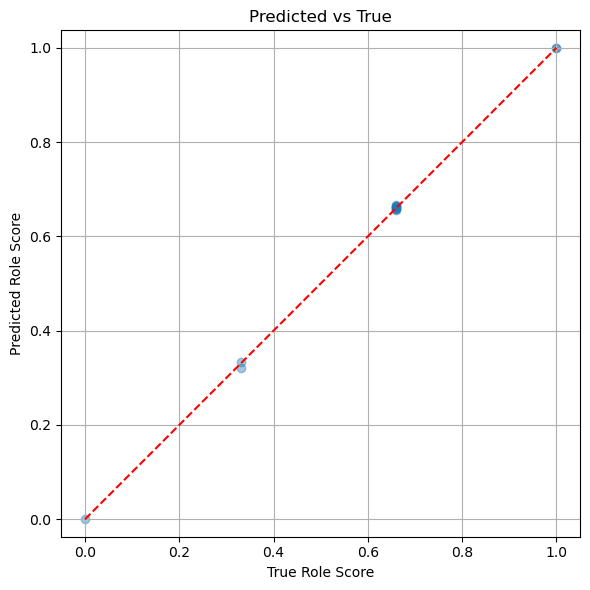

In [22]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([0, 1], [0, 1], 'r--')  # perfect prediction line
plt.xlabel("True Role Score")
plt.ylabel("Predicted Role Score")
plt.title("Predicted vs True")
plt.grid(True)
plt.axis("equal")
plt.tight_layout()
plt.show()


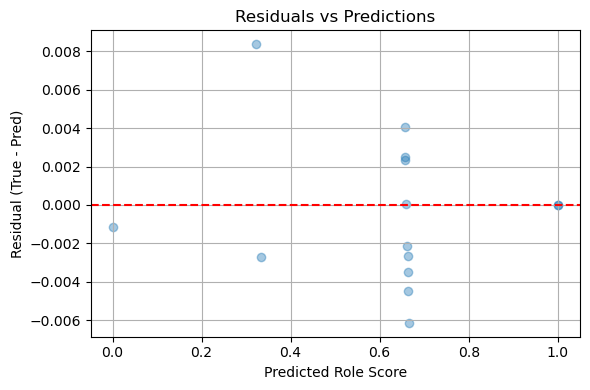

In [23]:
residuals = y_test - y_pred
plt.figure(figsize=(6,4))
plt.scatter(y_pred, residuals, alpha=0.4)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Role Score")
plt.ylabel("Residual (True - Pred)")
plt.title("Residuals vs Predictions")
plt.grid(True)
plt.tight_layout()
plt.show()
